# May 28, 2025: compare inferred communities with known systems 
resting state networks (RSNs), and their sub-networks (independent components (ICs)).

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats, linalg
from scipy.spatial.distance import jensenshannon, cosine
from scipy.stats import wilcoxon
from multiprocessing import Pool
import glob
import random
from joblib import Parallel, delayed
import re
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, SpectralCoclustering, SpectralClustering
from scipy.optimize import linear_sum_assignment, minimize
from scipy.spatial.distance import pdist, squareform
import umap
import phate

# import arviz as az

import ants
from nipype.interfaces import afni

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial

# networks
import graph_tool.all as gt
import networkx as nx
import pygraphviz as pgv

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from matplotlib.patches import Circle

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [5]:
args.source = 'allen'
args.space = 'ccfv2'
args.brain_div = 'whl'
args.num_rois = 172
args.resolution = 200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [6]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
ROI_SYS_path = f'{ROI_path}/canonical-systems/joanes'
os.system(f'mkdir -p {ROI_SYS_path}')
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [7]:
# relevant comms for plotting
if PARC_DESC == 'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200':
    args.relevant_comms = np.arange(0, 25)

In [8]:
def get_sys_vols(ic_files):
    ic_vols = []
    for ic_file in tqdm(ic_files):
        ic = int(os.path.basename(ic_file)[12:14])
        ic_vol = ants.image_read(ic_file).numpy()
        ic_vols.append(ic_vol)
        # break
    ic_vols = np.stack(ic_vols, axis=-1)
    print(ic_vols.shape)
    return ic_vols

In [9]:
# ic_files = sorted(glob.glob(f'{ROI_SYS_path}/ics/both/*desc-*.nii.gz', recursive=True))
# ics_df = pd.read_csv(f'{ROI_SYS_path}/desc-ic-names.csv')
# ic_vols = get_sys_vols(ic_files)
# ic_files

# lic_files = sorted(glob.glob(f'{ROI_SYS_path}/ics/left/*desc-*.nii.gz', recursive=True))
# l_ics_df = pd.read_csv(f'{ROI_SYS_path}/desc-lic-names.csv')
# lic_vols = get_sys_vols(lic_files)
# lic_files

# ric_files = sorted(glob.glob(f'{ROI_SYS_path}/ics/right/*desc-*.nii.gz', recursive=True))
# r_ics_df = pd.read_csv(f'{ROI_SYS_path}/desc-ric-names.csv')
# ric_vols = get_sys_vols(ric_files)
# ric_files

In [10]:
rsn_files = sorted(glob.glob(f'{ROI_SYS_path}/rsns/both/*desc-*.nii.gz', recursive=True))
rsns_df = pd.read_csv(f'{ROI_SYS_path}/desc-rsn-names.csv')
rsn_files

['/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/canonical-systems/joanes/rsns/both/hemi-B_desc-00.nii.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/canonical-systems/joanes/rsns/both/hemi-B_desc-01.nii.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/canonical-systems/joanes/rsns/both/hemi-B_desc-02.nii.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/canonical-systems/joanes/rsns/both/hemi-B_desc-03.nii.gz',
 '/home/govindas/new_mouse_dataset/roi-results-v3/source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200/canonical-systems/joanes/rsns/both/hemi-B_desc-04.nii.gz']

In [11]:
rsns_df

,Unnamed: 0,rsn,name,ics
0,0,4,basal ganglia,"[13, 12, 14]"
1,1,3,limbic,"[9, 8, 10, 11, 15, 16]"
2,2,2,olfactory,"[0, 17]"
3,3,1,sensory,"[1, 6, 7]"
4,4,0,somatosensory,"[2, 3, 4, 5]"


In [12]:
rsn_vols = get_sys_vols(rsn_files)

100%|██████████| 5/5 [00:00<00:00, 343.15it/s]

(57, 40, 66, 5)


In [13]:
parcels_img = ants.image_read(f'{PARCELS_path}/{PARC_DESC}_desc-parcels.nii.gz')
parcels_vol = parcels_img.numpy()
parcels_vol = np.round(parcels_vol, decimals=0)
roi_labels = pd.read_csv(f'{PARCELS_path}/{PARC_DESC}_desc-names.csv')['roi'].to_numpy()

In [14]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

---

In [15]:
marginals_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginals_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids

marginals_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.9943502824858758, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9082639088384565, 0.005617798206134892, 0....","[[0.8850912125784436, 0.09756830776993501, 0.0...","[[0.9881457547053836, 0.011854245294616511], [...","[[0.9952583018821535, 0.004741698117846605], [...","[[0.9976291509410767, 0.0023708490589233024], ...","[[0.9976291509410767, 0.0023708490589233024], ...","[[0.9976291509410767, 0.0023708490589233024], ...","[[1.0], [1.0], [1.0000000000000002], [1.0], [0...",0.177295,0
1,SLC01,sbm-nd-h,"[[0.9924242424242424, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9305555555555556, 0.0, 0.00751836547291092...","[[0.8583704854173055, 0.11905640763280642, 0.0...","[[0.9686317578785476, 0.03136824212145242], [0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...",0.132086,1
2,SLC01,sbm-nd-h,"[[0.9672131147540983, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9002956194571352, 0.0, 0.00792797635044343...","[[0.8373335842458809, 0.11451218593710696, 0.0...","[[0.9879460856908309, 0.012053914309169156], [...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...",0.122464,2
3,SLC01,sbm-nd-h,"[[0.989247311827957, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.9813851312290439, 0.0, 0.00011562030292519...","[[0.9137888107775382, 0.06490505861861601, 0.0...","[[0.9885271006993847, 0.011472899300615397], [...","[[0.997705420139877, 0.0022945798601230792], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",0.093199,3
4,SLC01,sbm-nd-h,"[[0.44565217391304346, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.9117334697438667, 0.028759166164648204, 0....","[[0.9033271327908874, 0.095322184980498, 0.000...","[[0.9909216966685239, 0.009078303331476], [0.9...","[[0.995460848334262, 0.004539151665738], [0.99...","[[0.995460848334262, 0.004539151665738], [0.99...","[[1.0], [1.0000000000000002], [1.0], [1.000000...","[[1.0], [1.0000000000000002], [1.0], [1.000000...","[[1.0], [1.0000000000000002], [1.0], [1.000000...",0.091858,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.02105398883751773, 0.00040523863029342963,...","[[0.9629751425533718, 0.0367510004382298, 0.00...","[[0.9914532557120393, 0.008546744287960418], [...","[[0.9982906511424077, 0.0017093488575920836], ...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...",0.233420,1
81,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.9869606077218264,...","[[0.9629514024881322, 0.037048597511867884, 0....","[[0.9919459570626374, 0.008054042937362584], [...","[[0.9991945957062638, 0.0008054042937362584], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...",0.226136,2
82,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.014634146341463415, 0.0, 0.0, 0.0, 0.0, 0....","[[0.9943370542744164, 0.0054487874864401434, 0...","[[0.9995046556830509, 0.000495344316949104], [...","[[0.9997523278415255, 0.000247672158474552], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",

In [16]:
cols = [col for col in  list(marginals_df.columns) if 'pi_' in col]
cols

['pi_0_aligned',
 'pi_1_aligned',
 'pi_2_aligned',
 'pi_3_aligned',
 'pi_4_aligned',
 'pi_5_aligned',
 'pi_6_aligned',
 'pi_7_aligned',
 'pi_8_aligned']

In [17]:
marginals_vol_df = marginals_df.copy(deep=True)
for idx, row in tqdm(marginals_vol_df.iterrows()):
    sub, sbm, mode = row[['sub', 'sbm', 'mode_id']]
    for col in cols:
        if np.isnan(row[col]).all() : continue
        level = col.split('_')[1]
        level = -1 if level == 'aligned' else int(level)
        if args.sbm in ['h']:
            file_name = f'mode-{mode:02d}_level-{level}.nii.gz'
        else:
            file_name = f'mode-{mode:02d}.nii.gz'
        vol_file = f'{ESTIM_path}/individual/sub-{sub}/partition-modes-group-aligned/{SBM}/marginal-visuals/res-{args.resolution}/nii/{file_name}'
        vol = ants.image_read(vol_file).numpy()
        marginals_vol_df.at[idx, col] = vol * (vol > 0.2)
    #     break
    # break

0it [00:00, ?it/s]

85it [00:07, 10.88it/s]


In [18]:
def resemblance(sys_vol, comm_vol, measure='specificity'):
    # resemblance measures
    x = np.sum(comm_vol * sys_vol)
    s = x / np.sum(comm_vol) # specificity
    c = x / np.sum(sys_vol) # coverage
    f = 2 * s * c / (s + c) # correspondence: harmonic mean

    if measure == 'specificity':
        return np.nan_to_num(s)
    if measure == 'coverage':
        return np.nan_to_num(c)
    if measure == 'correspondence':
        return np.nan_to_num(f)
    return 0.0

normalize = lambda matrix: np.nan_to_num(matrix / np.sum(matrix, axis=0))

def get_resemblance_matrix_per_mode(sys_vols, comm_vols, measure='specificity'):
    if np.isnan(comm_vols).all(): return np.nan
    
    num_sys = sys_vols.shape[-1]
    if len(comm_vols.shape) == 4: num_comms = comm_vols.shape[-1]
    else: num_comms = 1
    X = np.zeros((num_sys, num_comms))

    results = Parallel(n_jobs=10, backend='loky')(
        delayed(resemblance)(
            sys_vols[..., i], 
            comm_vols[..., j] if num_comms > 1 else comm_vols, 
            measure
        )
        for (i, j) in list(product(range(num_sys), range(num_comms)))
    )
    for idx, (i, j) in enumerate(list(product(range(num_sys), range(num_comms)))):
        X[i, j] = results[idx]
    
    X = normalize(X) # ensure resemblances sum to 1

    return X

In [19]:
def get_estim_df(marginals_vol_df, sys_vols, measure='specificity'):
    estim_df = pd.concat(
        [
            marginals_vol_df[['sub', 'sbm']],
            marginals_vol_df[cols].applymap(lambda comm_vols: get_resemblance_matrix_per_mode(
                sys_vols, comm_vols, measure,
            )),
            marginals_vol_df[['omega', 'mode_id']],
        ],
        axis=1
    )
    return estim_df

In [20]:
def get_membership_matrix(num_rois, df, col='pi'):
    pis = [np.zeros((num_rois, 1)) if np.isnan(pi).all() else pi for pi in df[col]]

    num_rois = num_rois
    num_modes = len(df)
    num_comms = np.max([pi.shape[-1] for pi in pis])
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix
    
    for idx_mode, pi in enumerate(pis):
        M[:, idx_mode, :pi.shape[-1]] = pi
    
    return M

def get_soft_estim_df(estim_df, num_sys):
    soft_estim_df = []
    for sub, group in estim_df.groupby('sub'):
        omegas = group['omega'].to_list()
        dct = {'sub':[sub], 'sbm':[SBM]}
        for col in cols:
            M = get_membership_matrix(num_sys, group, col=col)
            soft_X = np.average(M, axis=1, weights=omegas)
            dct[col] = [soft_X]
        soft_estim_df += [pd.DataFrame(dct)]
    soft_estim_df = pd.concat(soft_estim_df).reset_index(drop=True)
    return soft_estim_df

In [21]:
def save_individual_estimates(estim_df, sys_name='rsn', measure='specificity'):
    for sub, group in estim_df.groupby('sub'):
        folder = f'{ESTIM_path}/individual/sub-{sub}/resemblance-with-known-systems/{SBM}'
        os.system(f'mkdir -p {folder}')
        with open(f'{folder}/sys-{sys_name}_desc-{measure}.pkl', 'wb') as f:
            pickle.dump(group, f)

specificity to rsns

In [22]:
sys_name = 'rsn'
sys_vols = rsn_vols
num_sys = sys_vols.shape[-1]
measure = 'specificity'
sys_df = rsns_df

In [23]:
specificity_df = get_estim_df(marginals_vol_df, sys_vols, measure)
soft_specificity_df = get_soft_estim_df(specificity_df, num_sys)
save_individual_estimates(specificity_df, sys_name, measure)

/tmp/ipykernel_1009087/1395378944.py:6: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_1009087/1395378944.py:6: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_1009087/1395378944.py:6: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_1009087/1395378944.py:6: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_1009087/1395378944.py:6: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_1009087/1395378944.py:6: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_1009087/1395378944.py:6: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_1009087/1395378944.py:6: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_1009087/1395378944.py:6: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_1009087/1395378944.py:6: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipyke

In [24]:
specificity_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.0, 0.3682709336280823, 0.0, 0.0, 0.0, 0.0,...","[[0.25851096389127526, 0.2056077585042101, 0.0...","[[0.12203553233661228, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.12354873437656938, 0.0], [0.45043041265175...","[[0.12363512234731878, 0.0], [0.45000878176300...","[[0.1236636493353936, 0.0], [0.449869443284122...","[[0.1236636493353936, 0.0], [0.449869443284122...","[[0.1236636493353936, 0.0], [0.449869443284122...","[[0.1236920820977973], [0.44973065215683056], ...",0.177295,0
1,SLC01,sbm-nd-h,"[[0.0, 0.3541247459724394, 0.0, 0.0, 0.0, 0.0,...","[[0.2321203433320641, 0.16958798278583606, 0.0...","[[0.12356390516200344, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.12368186246098213, 0.0], [0.44963432169164...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...",0.132086,1
2,SLC01,sbm-nd-h,"[[0.0, 0.35928704263904565, 0.0, 0.0, 0.0, 0.0...","[[0.15634730412192588, 0.0, 0.0, 0.34688383332...","[[0.11972571145583691, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.12336141734293353, 0.0], [0.45064697259149...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...",0.122464,2
3,SLC01,sbm-nd-h,"[[0.0, 0.36760484865860504, 0.0, 0.0, 0.0, 0.0...","[[0.3328092247013401, 0.17724864147406114, 0.0...","[[0.12919892596068272, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.12409062898534558, 0.0], [0.44867134225424...","[[0.12377046878378713, 0.0], [0.44952234234082...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...",0.093199,3
4,SLC01,sbm-nd-h,"[[0.0, 0.35037358551104114, 0.1315031400693103...","[[0.18719750528952994, 0.24536601495450602, 0....","[[0.12402878523703015, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.12373356333490837, 0.0], [0.44959682513181...","[[0.1237127536100166, 0.0], [0.449663972779623...","[[0.1237127536100166, 0.0], [0.449663972779623...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...",0.091858,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.344877541065...","[[0.3696350537903991, 0.0, 0.0, 0.0, 0.1665612...","[[0.1223607673232743, 0.0, 0.0], [0.4558565303...","[[0.12357025773549561, 0.0], [0.45108983460368...","[[0.1236680014594388, 0.0], [0.449999157610397...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...",0.233420,1
81,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.347677767276...","[[0.34738631026967365, 0.0, 0.0, 0.0, 0.166041...","[[0.12241547328450739, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.123517147281334, 0.0], [0.4505460344843103...","[[0.12367482199189923, 0.0], [0.44981110292740...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...",0.226136,2
82,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.342746118143...","[[0.5056474623242176, 0.0, 0.0, 0.0, 0.1667156...","[[0.1218591289145773, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.12359329280691753, 0.0], [0.45058350711193...","[[0.12364279530514682, 0.0], [0.45015623199911...","[[0.1236920820977973], [0.44973065215683056], ...",

In [25]:
for idx, row in tqdm(soft_specificity_df.iterrows()):
    sub = row['sub']
    folder = f'{ESTIM_path}/individual/sub-{sub}/resemblance-with-known-systems/{SBM}'
    os.system(f'mkdir -p {folder}')

    for col in cols:
        X = row[col]
        try: X = X[:, args.relevant_comms]
        except: pass
        n_comms = X.shape[-1]

        ncols = 1
        nrows = 1
        fig, axs = plt.subplots(nrows, ncols, figsize=(n_comms*ncols, 6*nrows),)
        fig.tight_layout(h_pad=3, w_pad=3)
        fig.suptitle(f'{SBM} {col} {sub}', x=0.0, y=1.0)
        ax = axs
        
        sns.heatmap(X, ax=ax, annot=True, fmt='.2f', yticklabels=rsns_df['name'].to_list(), cmap=cc.cm.CET_L12)
        ax.set(xlabel=f'comm', ylabel=f'{sys_name}', title=f'{measure} matrix')

        fig.savefig(f'{folder}/col-{col}_sys-{sys_name}_desc-{measure}-matrix.pdf', bbox_inches='tight')

    plt.close('all')

9it [00:24,  2.68s/it]


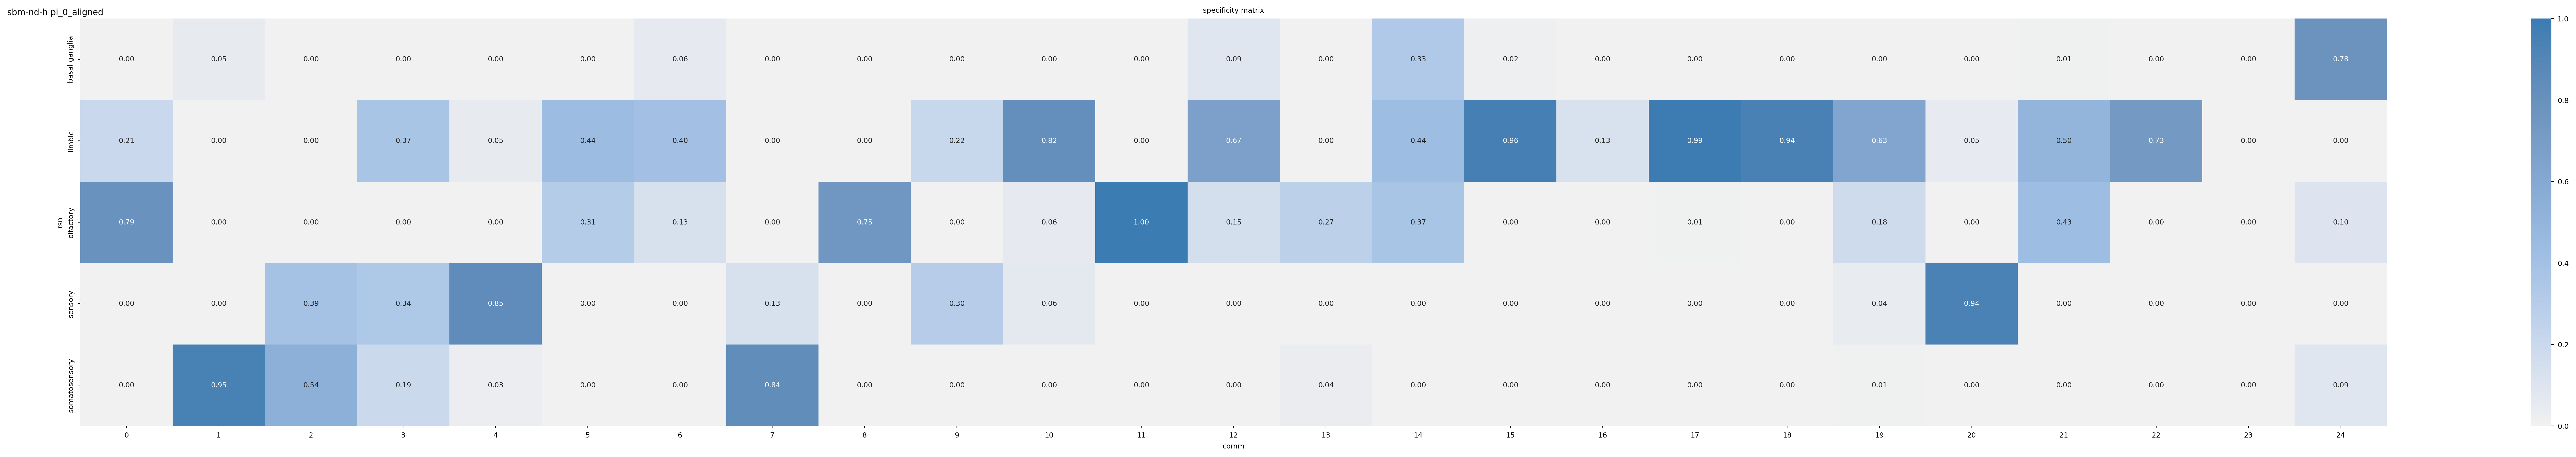

In [26]:
folder = f'{ESTIM_path}/group/resemblance-with-known-systems/{SBM}'
os.system(f'mkdir -p {folder}')

col = cols[0]
Xs = get_membership_matrix(num_sys, soft_specificity_df, col=col)
n_comms = Xs.shape[-1]

ncols = 1
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(n_comms*ncols, 6*nrows),)
fig.tight_layout(h_pad=3, w_pad=3)
fig.suptitle(f'{SBM} {col}', x=0.0, y=1.0)
ax = axs
mean_X = np.median(Xs, axis=1)[:, args.relevant_comms]
sns.heatmap(mean_X, ax=ax, annot=True, fmt='.2f', yticklabels=rsns_df['name'].to_list(), cmap=cc.cm.CET_L12)
ax.set(xlabel=f'comm', ylabel=f'{sys_name}', title=f'{measure} matrix')

fig.savefig(f'{folder}/col-{col}_sys-{sys_name}_desc-{measure}-matrix.pdf', bbox_inches='tight')
# plt.close('all')

In [27]:
# visualizing the matrix and specificity values in 2D as a graph layout.

In [28]:
Xs = get_membership_matrix(num_sys, soft_specificity_df, col=col)
group_X = np.median(Xs, axis=1)
relevant_comms = [0, 1, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 19, 20, 21, 24]

In [29]:
def bootstrap(matrices, statistic=np.median, n_bootstrap=100):
    stacked = np.stack(matrices)
    bootstrap_means = np.stack([
        statistic(resample(stacked), axis=0)
        for _ in range(n_bootstrap)
    ])
    return (
        statistic(bootstrap_means, axis=0),
        bootstrap_means
    )

In [30]:
estim_df = soft_specificity_df
group_specificity_df = []
for col in cols:
    M = get_membership_matrix(num_sys, estim_df, col=col)
    median_mat, boot_median_mats = bootstrap(
        [M[:, i, :] for i in range(M.shape[1])],
    )
    row = pd.DataFrame(dict(
        sbm=[SBM],
        col=[col],
        vals=[np.squeeze(M)],
        mean=[median_mat],
        boot_means=[boot_median_mats],
    ))
    group_specificity_df += [row]
group_specificity_df = pd.concat(group_specificity_df).reset_index(drop=True)

df = group_specificity_df.copy()
df_melted = df.melt(
    id_vars=['sbm', 'col'],
    value_vars=['vals', 'mean', 'boot_means'],
    var_name='stat',
    value_name='value',
)
df_pivot = df_melted.pivot(
    index=['sbm', 'stat'],
    columns='col',
    values='value',
).reset_index()
group_specificity_df = df_pivot.copy()

group_specificity_df

col,sbm,stat,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,sbm-nd-h,boot_means,"[[[0.0, 0.07580894524997799, 0.0, 0.0, 0.0, 0....","[[[0.33819980412690265, 0.05526165112963835, 0...","[[[0.12243217980032405, 0.011321270920434563, ...","[[[0.1235246191277853, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.12354263092723995, 0.0], [0.4499349206368...","[[[0.12368893994958621, 0.0], [0.4497487774809...","[[[0.1236920820977973, 0.0], [0.44973065215683...","[[[0.1236920820977973, 0.0], [0.44973065215683...","[[[0.1236920820977973], [0.44973065215683056],..."
1,sbm-nd-h,mean,"[[0.0, 0.04844434854130539, 0.0, 0.0, 0.0, 0.0...","[[0.21681180587745855, 0.02189334972519349, 0....","[[0.12243217980032405, 0.011321270920434563, 0...","[[0.12354995786950755, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.1236772994470175, 0.0], [0.449825801511440...","[[0.1236920820977973, 0.0], [0.449748115964344...","[[0.1236920820977973, 0.0], [0.449730652156830...","[[0.1236920820977973, 0.0], [0.449730652156830...","[[0.1236920820977973], [0.44973065215683056], ..."
2,sbm-nd-h,vals,"[[[0.0, 0.36868951012416945, 0.057915416762781...","[[[0.20950304253464114, 0.19222629575524952, 0...","[[[0.12319648746041717, 5.600186735884447e-06,...","[[[0.12360134578024456, 0.0, 0.0, 0.0, 0.0, 0....","[[[0.1236772994470175, 0.0], [0.12349372308904...","[[[0.12368893994958621, 0.0], [0.1236658095695...","[[[0.12368704109813371, 0.0], [0.1236788340644...","[[[0.12368704109813371, 0.0], [0.1236920820977...","[[0.1236920820977973, 0.1236920820977973, 0.12..."


In [31]:
# box plots of specificity values

100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


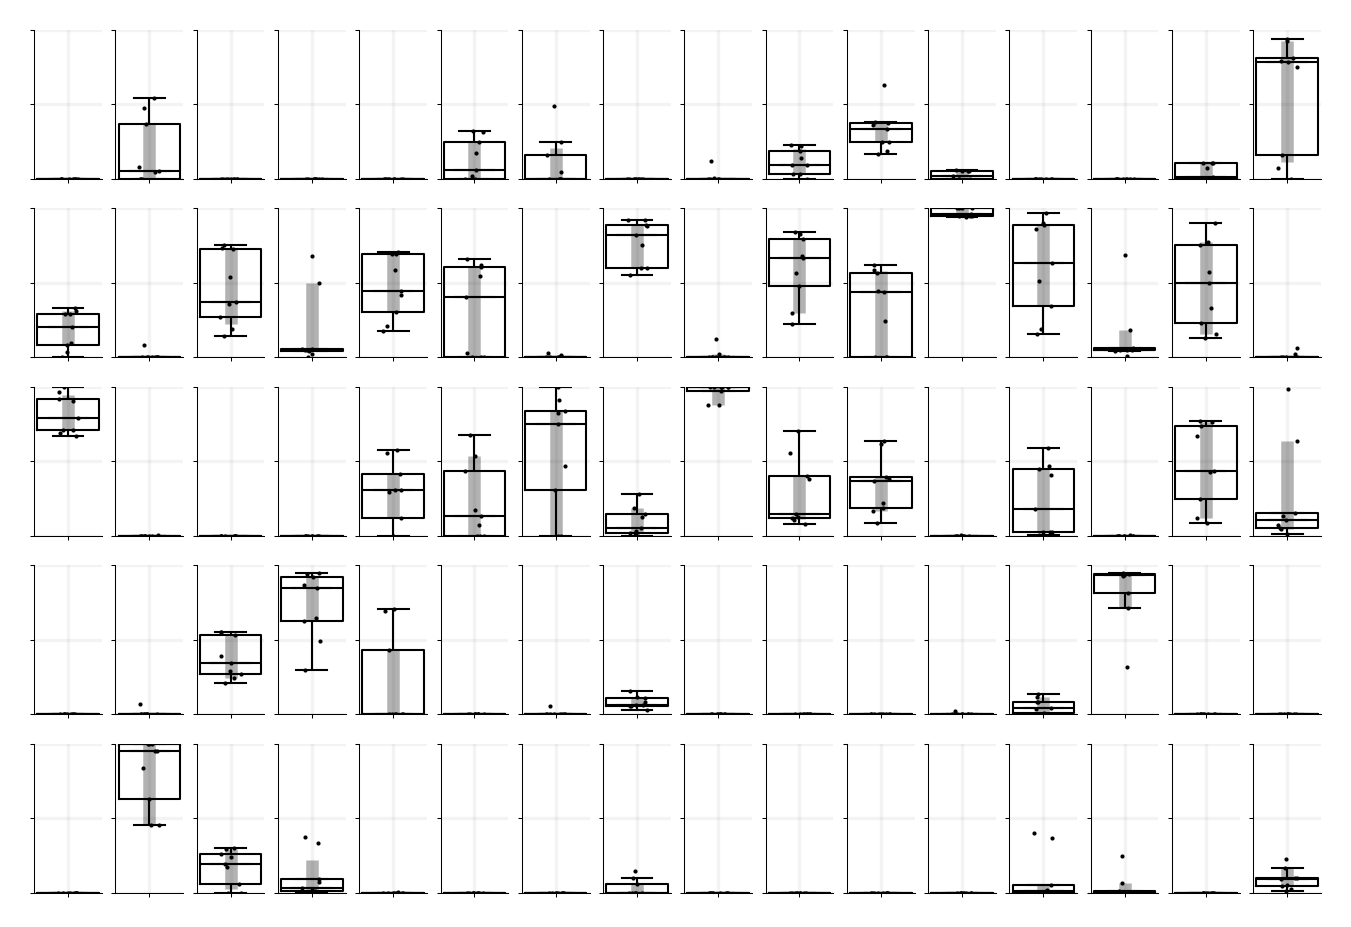

In [32]:
# === Data Setup ===
soft_Xs = Xs[:, :, relevant_comms]  # shape: (5 RSNs, 9 animals, 24 communities)
rsn_names = ['basal ganglia', 'limbic', 'olfactory', 'sensory', 'somatosensory']
comm_labels = [str(i) for i in relevant_comms]

# === Plot Setup ===
pt_to_in = 1 / 72.27
w_pt, h_pt = 25, 54  # axes size in points
fig_w = w_pt * soft_Xs.shape[2] * pt_to_in
fig_h = h_pt * soft_Xs.shape[0] * pt_to_in

fig, axs = plt.subplots(
    nrows=soft_Xs.shape[0],
    ncols=soft_Xs.shape[2],
    figsize=(fig_w, fig_h),
    squeeze=False, 
    dpi=300,
)

for r in tqdm(range(soft_Xs.shape[0])):
    for c in range(soft_Xs.shape[2]):
        ax = axs[r, c]
        
        sns.boxplot(
            y=soft_Xs[r, :, c],
            ax=ax,
            width=0.6,
            color='#000000',
            fliersize=0,
            fill=False,
            linewidth=0.5,
        )
        
        sns.stripplot(
            y=soft_Xs[r, :, c],
            ax=ax,
            color='#000000',
            size=1, 
            jitter=0.1,
        )
        
        vals = soft_Xs[r, :, c]
        point, boot_points = bootstrap(vals, statistic=np.median, n_bootstrap=100)
        ci_l, ci_u = np.percentile(boot_points, [2.5, 97.5])
        
        ax.hlines(point, xmin=-0.2, xmax=0.2, color='black', linewidth=0.5)
        ax.vlines(0, ci_l, ci_u, color='black', linewidth=3.0, alpha=0.3)
        
        ax.set_ylim(0, 1)
        ax.tick_params(
            axis='y', which='major', direction='out', 
            length=1.0, width=0.25,
            labelsize=0, 
        )
        ax.tick_params(
            axis='x', which='major',
            direction='out', length=1.0, width=0.25,
            labelsize=0,
        )
        ax.set_xticks([0])
        ax.set_yticks([0, 0.5, 1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(alpha=0.15)
        
        for spine_loc, spine in ax.spines.items():
            if spine_loc in ['left', 'bottom']:
                spine.set_visible(True)
                spine.set_linewidth(0.25)
            else:
                spine.set_visible(False)

In [33]:
folder = f'{ESTIM_path}/group/resemblance-with-known-systems/{SBM}'
os.system(f'mkdir -p {folder}')
fig.savefig(f'{folder}/col-{col}_sys-{sys_name}_desc-{measure}-matrix-boxplots.svg', bbox_inches='tight')

## 2D projection of comms

In [34]:
soft_specificity_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,SLC01,sbm-nd-h,"[[0.0, 0.36868951012416945, 0.0579154167627817...","[[0.20950304253464114, 0.19222629575524952, 0....","[[0.12319648746041717, 5.600186735884447e-06, ...","[[0.12360134578024456, 0.0], [0.45002574447832...","[[0.1236772994470175, 0.0], [0.449784702082753...","[[0.12368893994958621, 0.0], [0.44974913413444...","[[0.12368704109813371, 0.0], [0.44975525919346...","[[0.12368704109813371, 0.0], [0.44975525919346...","[[0.1236920820977973], [0.44973065215683056], ..."
1,SLC03,sbm-nd-h,"[[0.0, 0.04844434854130539, 0.0, 0.0, 0.0, 0.0...","[[0.21681180587745855, 0.0, 0.0, 0.17063204238...","[[0.10614257014447748, 0.10175459337161881, 0....","[[0.12231432968761285, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.12349372308904041, 0.0], [0.44993442112910...","[[0.12366580956952246, 0.0], [0.44976000865529...","[[0.12367883406442952, 0.0], [0.44974351028330...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ..."
2,SLC04,sbm-nd-h,"[[0.0, 0.47289898123877966, 0.4485289539752825...","[[0.06518674200215778, 0.2589188339605764, 0.0...","[[0.12273237715697335, 0.016352052496313673, 0...","[[0.12354995786950755, 0.0], [0.45060912330641...","[[0.12368079867200071, 0.0], [0.44982580151144...","[[0.1236896502505095, 0.0], [0.449748777480933...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ..."
3,SLC05,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020806077662...","[[0.33819980412690265, 0.0, 0.0034896186874006...","[[0.12419108513230787, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.12380870440254986, 0.0, 0.0, 0.0, 0.0], [0...","[[0.12372609669021567, 0.0], [0.44987436241570...","[[0.12369350539078715, 0.0], [0.44974811596434...","[[0.1236920820977973], [0.4497306521568306], [...","[[0.1236920820977973], [0.4497306521568306], [...","[[0.1236920820977973], [0.4497306521568306], [..."
4,SLC06,sbm-nd-h,"[[0.0, 0.07580894524997799, 0.0, 0.0, 0.0, 0.0...","[[0.5181334761833356, 0.0, 0.0, 0.022219899022...","[[0.12446352961693856, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.12380360138686106, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.12370614855571693, 0.0], [0.44967519582788...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ..."
5,SLC07,sbm-nd-h,"[[0.0, 0.0430939284458222, 0.0, 0.0, 0.0, 0.0,...","[[0.021274283926513145, 0.0, 0.0, 0.2084638403...","[[0.11878172461115456, 0.07116745027882453, 0....","[[0.12315087207195004, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.12354263092723995, 0.0], [0.45023795832078...","[[0.1236920820977973], [0.4497306521568306], [...","[[0.1236920820977973], [0.4497306521568306], [...","[[0.1236920820977973], [0.4497306521568306], [...","[[0.1236920820977973], [0.4497306521568306], [..."
6,SLC08,sbm-nd-h,"[[0.0, 0.0005001330501154419, 0.0, 0.0, 0.0, 0...","[[0.5709503492224898, 0.05526165112963835, 0.0...","[[0.1258431714076845, 0.011321270920434563, 0....","[[0.12385077031140365, 0.0, 0.0, 0.0, 0.0], [0...","[[0.12371454464569984, 0.0], [0.44975950785951...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ...","[[0.1236920820977973], [0.44973065215683056], ..."
7,SLC09,sbm-nd-h,"[[0.0, 0.5412570958708305, 0.0, 0.0, 0.0, 0.0,...","[[0.05014116576012429, 0.34792054149444396, 0....","[[0.11711965592011699, 0.016863855112108212, 0...","[[0.12299179959592409, 0.0, 0.0, 0.0, 0.0], [0...","[[0.1236714105657517, 0.0], [0.449787952740209...","[[0.12369208209779732], [0.4497306521568306], ...","[[0.12369208209779732], [0.4497306521568306], ...","[[0.12369208209779732], [0.4497306521568306], ...","[[0.12369208209779732], [0.4497306521568306],

In [35]:
col = cols[0]
rows = []
for idx_row, row in soft_specificity_df.iterrows():
    sub, sbm = row[['sub', 'sbm']]
    S = row[col]
    for comm in range(S.shape[-1]):
        rows.append(dict(
            sub=sub,
            sbm=sbm,
            col=col,
            comm=comm,
            vec=S[:, comm],
        ))
    # break
soft_vec_df = pd.DataFrame(rows)
soft_vec_df = soft_vec_df[soft_vec_df['comm'].isin(relevant_comms)]
soft_vec_df

,sub,sbm,col,comm,vec
0,SLC01,sbm-nd-h,pi_0_aligned,0,"[0.0, 0.07948631889085404, 0.9205136811091461,..."
1,SLC01,sbm-nd-h,pi_0_aligned,1,"[0.36868951012416945, 0.0, 0.00254936114586607..."
3,SLC01,sbm-nd-h,pi_0_aligned,3,"[0.0, 0.37028089377069084, 0.0, 0.388942315592..."
4,SLC01,sbm-nd-h,pi_0_aligned,4,"[0.0, 0.05047608225323264, 0.0, 0.949523917746..."
5,SLC01,sbm-nd-h,pi_0_aligned,5,"[0.0, 0.5838921519399142, 0.41610784806008594,..."
...,...,...,...,...,...
298,SLC10,sbm-nd-h,pi_0_aligned,15,"[0.0, 1.0, 0.0, 0.0, 0.0]"
302,SLC10,sbm-nd-h,pi_0_aligned,19,"[0.0, 0.8607183050411618, 0.024582100915948188..."
303,SLC10,sbm-nd-h,pi_0_aligned,20,"[0.0, 0.05832560544785306, 0.0, 0.941674394552..."
304,SLC10,sbm-nd-h,pi_0_aligned,21,"[0.10810089198850151, 0.1573110099317321, 0.73..."


In [36]:
# col = cols[0]
# rows = []
# for idx_row, row in group_specificity_df.iterrows():
#     sbm = row['sbm']
#     stat = row['stat']
#     if stat == 'boot_means':
#         S = row[col]
#         for idx_boot in range(S.shape[0]):
#             for comm in range(S.shape[-1]):
#                 rows.append(dict(
#                     sbm=sbm,
#                     col=col,
#                     stat=stat,
#                     idx_boot=idx_boot,
#                     comm=comm,
#                     vec=S[idx_boot, :, comm],
#                 ))
#         # break
#     # break
# group_boot_vec_df = pd.DataFrame(rows)
# group_boot_vec_df = group_boot_vec_df[group_boot_vec_df['comm'].isin(relevant_comms)]
# group_boot_vec_df

In [37]:
rsn_vecs = np.eye(5)

In [38]:
X_rsn = [v for v in rsn_vecs]
X_orig = soft_vec_df['vec'].to_list()
# X_boot = group_boot_vec_df['vec'].to_list()
X = np.stack(X_rsn + X_orig) # + X_boot)
X.shape

(149, 5)

### BARYCENTRIC

In [108]:
def get_rsn_positions(n_rsn=5, radius=1.0):
    angles = np.linspace(0, 2*np.pi, n_rsn, endpoint=False)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    return np.vstack([x, y]).T

In [109]:
n_rsn = len(rsns_df)
rsn_pos = get_rsn_positions()
# adjust rsn positions for better plotting purposes
rsn_pos = rsn_pos[[0, 4, 2, 3, 1]]
x_rsn, y_rsn = rsn_pos[:, 0], rsn_pos[:, 1]
x_rsn, y_rsn

(array([ 1.        ,  0.30901699, -0.80901699, -0.80901699,  0.30901699]),
 array([ 0.        , -0.95105652,  0.58778525, -0.58778525,  0.95105652]))

In [110]:
xs, ys = [], []
for idx, row in soft_vec_df.iterrows():
    x_comm, y_comm = (rsn_pos.T @ row['vec'][:, None])[:, 0]
    xs.append(x_comm)
    ys.append(y_comm)
soft_vec_df['x'] = xs
soft_vec_df['y'] = ys
soft_vec_df

,sub,sbm,col,comm,vec,x,y
0,SLC01,sbm-nd-h,pi_0_aligned,0,"[0.0, 0.07948631889085404, 0.9205136811091461,...",-0.720149,0.465468
1,SLC01,sbm-nd-h,pi_0_aligned,1,"[0.36868951012416945, 0.0, 0.00254936114586607...",0.560925,0.599486
3,SLC01,sbm-nd-h,pi_0_aligned,3,"[0.0, 0.37028089377069084, 0.0, 0.388942315592...",-0.125834,-0.351780
4,SLC01,sbm-nd-h,pi_0_aligned,4,"[0.0, 0.05047608225323264, 0.0, 0.949523917746...",-0.752583,-0.606122
5,SLC01,sbm-nd-h,pi_0_aligned,5,"[0.0, 0.5838921519399142, 0.41610784806008594,...",-0.156206,-0.310732
...,...,...,...,...,...,...,...
298,SLC10,sbm-nd-h,pi_0_aligned,15,"[0.0, 1.0, 0.0, 0.0, 0.0]",0.309017,-0.951057
302,SLC10,sbm-nd-h,pi_0_aligned,19,"[0.0, 0.8607183050411618, 0.024582100915948188...",0.153295,-0.871561
303,SLC10,sbm-nd-h,pi_0_aligned,20,"[0.0, 0.05832560544785306, 0.0, 0.941674394552...",-0.743807,-0.608973
304,SLC10,sbm-nd-h,pi_0_aligned,21,"[0.10810089198850151, 0.1573110099317321, 0.73...",-0.437582,0.282168


In [111]:
comm_coords = soft_vec_df[['x', 'y']].to_numpy()

In [112]:
n_bootstrap = 100
result = []
for comm, group in soft_vec_df.groupby('comm'):
    xs = group['x']
    ys = group['y']
    
    boot_medians = np.stack([
        [np.median(resample(xs)), np.median(resample(ys))]
        for _ in range(n_bootstrap)
    ])
    result.append(dict(
        comm=comm,
        x_median=np.median(xs),
        y_median=np.median(ys),
        boot_xs=boot_medians[:, 0],
        boot_ys=boot_medians[:, 1],
    ))
boot_vec_df = pd.DataFrame(result)
boot_vec_df

,comm,x_median,y_median,boot_xs,boot_ys
0,0,-0.579250,0.271538,"[-0.5792502614409265, -0.4849739877070661, -0....","[0.1386413945679793, 0.1386413945679793, 0.271..."
1,1,0.342491,0.904983,"[0.33804880979979124, 0.3424912159355663, 0.34...","[0.9503889578010508, 0.9503889578010508, 0.390..."
2,3,-0.074488,-0.385607,"[-0.07448816266244429, -0.013995860992336266, ...","[-0.5205014815608061, -0.5205014815608061, -0...."
3,4,-0.637955,-0.556036,"[-0.41122742428068704, -0.7254336035783672, -0...","[-0.4949126906617996, -0.5877150017740576, -0...."
4,5,-0.281382,-0.474915,"[-0.3382000706688835, -0.03691975057621138, -0...","[-0.47748689718520415, -0.47491543491773136, -..."
5,6,-0.000002,-0.068046,"[0.0, 0.0, -0.05137252322972065, -0.0513725232...","[-0.06804627321146024, -7.449957005641411e-06,..."
6,8,-0.365187,0.439546,"[-0.36518702163743116, -0.36518702163743116, 0...","[0.17927508985203716, 0.47182237716149394, 0.1..."
7,10,0.179649,-0.796334,"[0.17964932827844962, 0.1866596131794222, 0.21...","[-0.8463346839957073, -0.8463346839957073, -0...."
8,11,-0.809017,0.587785,"[-0.8090169943749475, -0.8090169943749473, -0....","[0.5877852522924731, 0.587785252292473, 0.5877..."
9,12,0.186079,-0.548506,"[0.1860789549075448, -0.02356259756530942, 0.1...","[-0.6838988080023615, -0.5808701120549697, -0...."


In [113]:
median_coords = boot_vec_df[['x_median', 'y_median']].to_numpy()

[[], [], Text(0.5, 0, ''), Text(0, 0.5, '')]

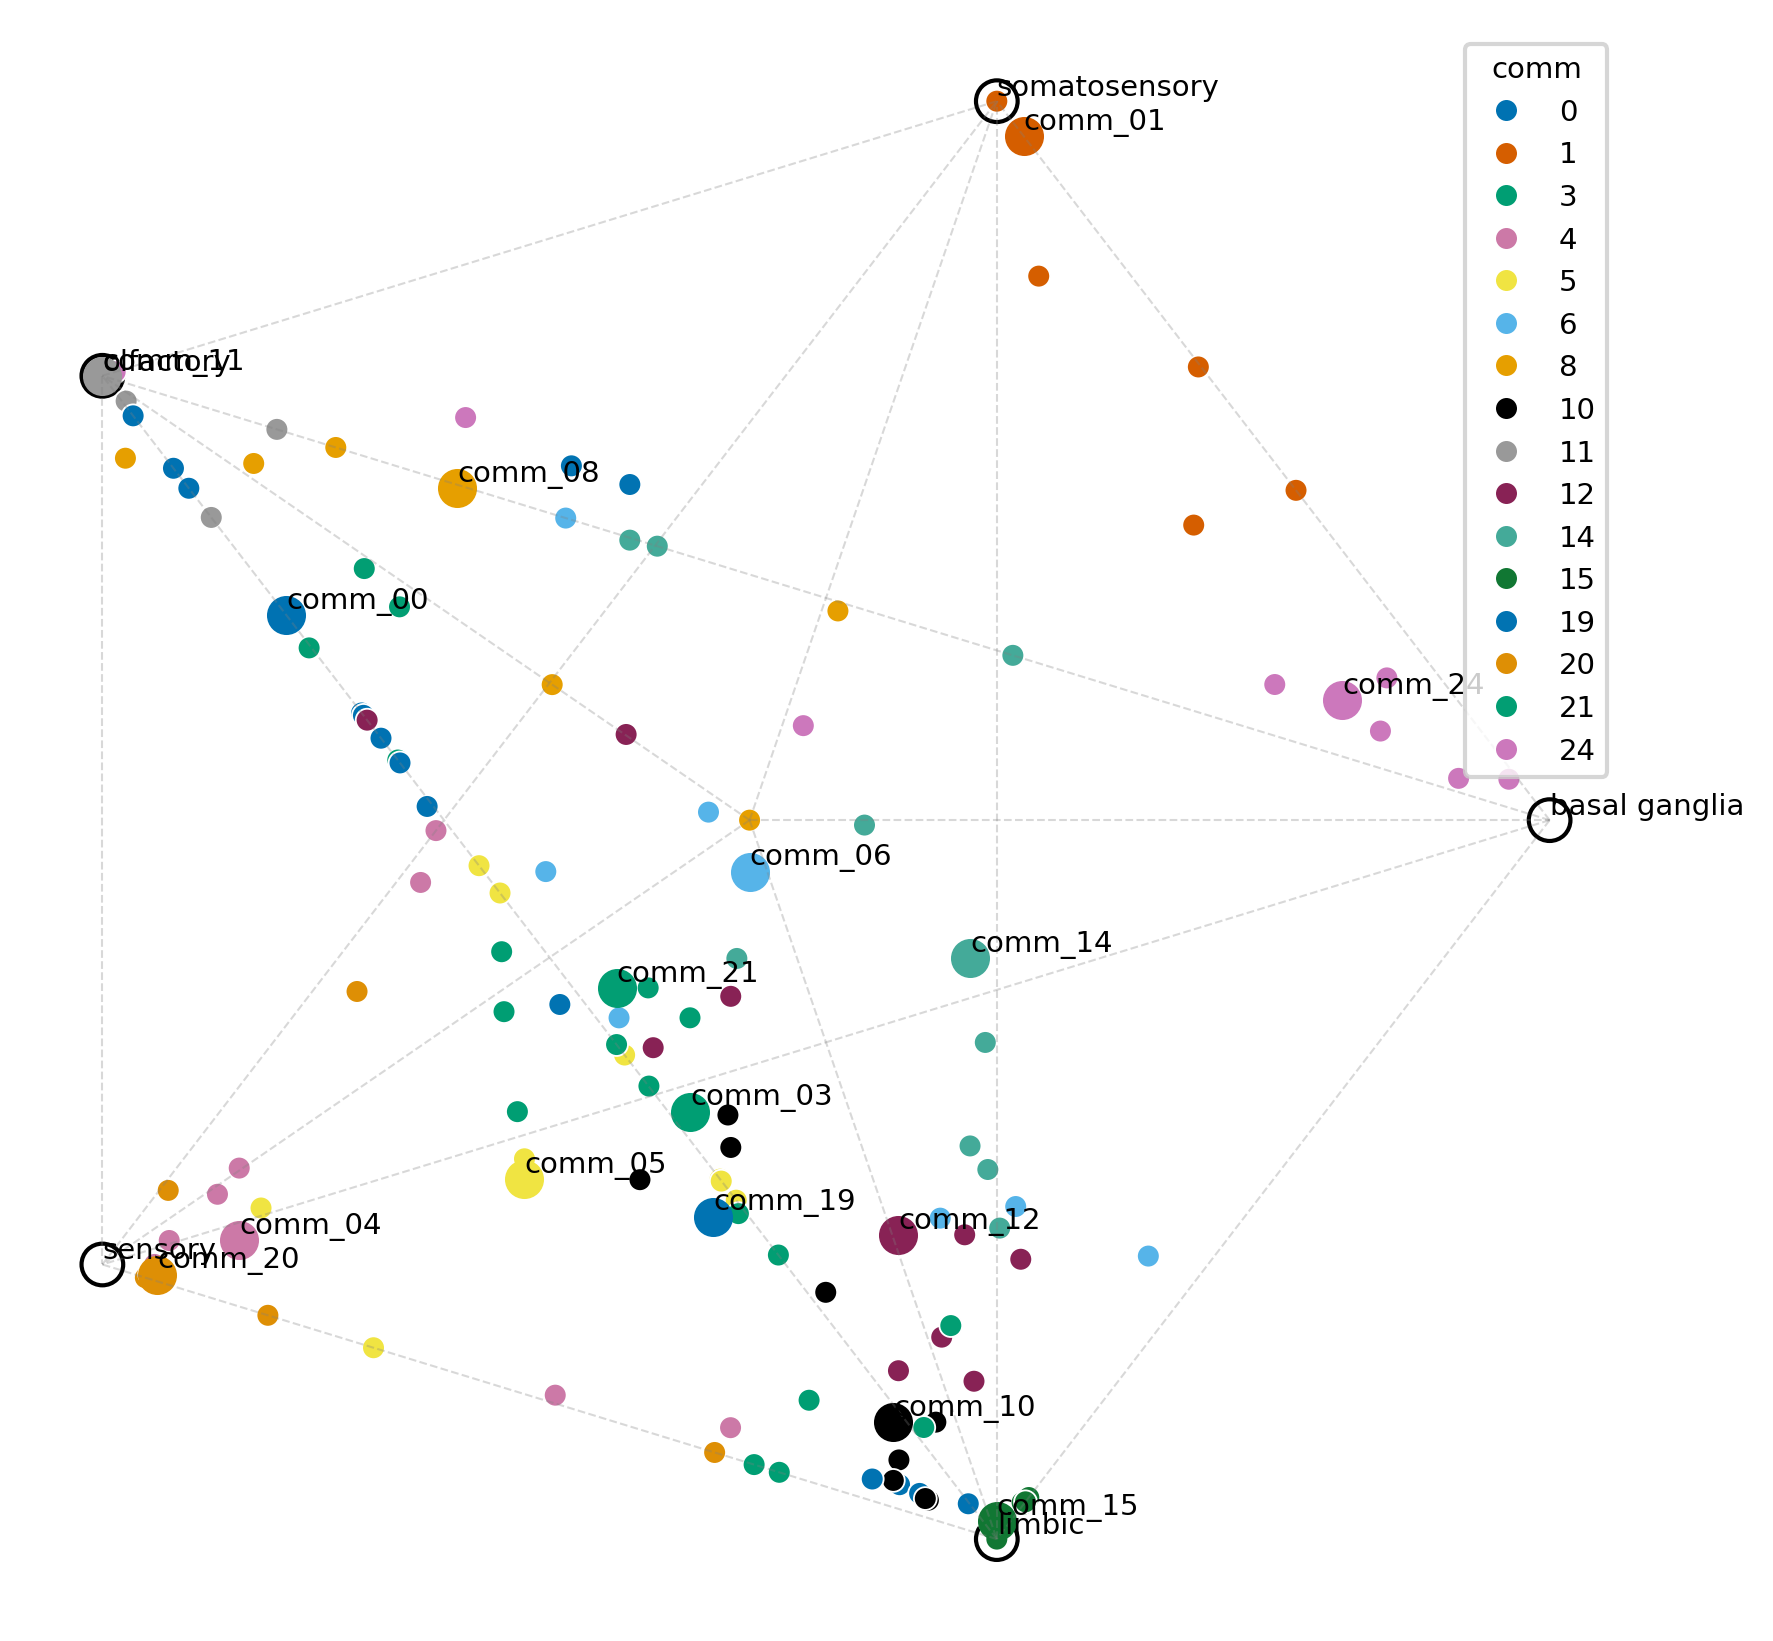

In [114]:

fig, ax = plt.subplots(1, 1, figsize=(493/72, 493/72), dpi=300)

x_offset = 0
y_offset = 0
    
for idx_rsn in range(n_rsn):
    ax.scatter(
        x_rsn[idx_rsn], y_rsn[idx_rsn], 
        s=100, alpha=1.0, #c='black'
        facecolors='none', edgecolors='black',
    )
    ax.text(
        x_rsn[idx_rsn]+x_offset, y_rsn[idx_rsn]+y_offset,
        # f'rsn_{idx_rsn:02d}',
        f'{rsns_df.at[idx_rsn, "name"]}',
        fontsize=7, ha='left', va='bottom',
    )

for p1, p2 in combinations(rsn_pos, 2):
    x0, y0 = p1
    x1, y1 = p2
    ax.plot([x0, x1], [y0, y1], linestyle='--', color='grey', linewidth=0.5, alpha=0.3)

for i in range(len(rsn_pos)):
    x, y = rsn_pos[i, 0], rsn_pos[i, 1]
    ax.plot([0, x], [0, y], linestyle='--', color='grey', linewidth=0.5, alpha=0.3)

sns.scatterplot(
    soft_vec_df,
    x='x', y='y',
    ax=ax,
    hue='comm',
    s=30,
    palette=CUD_COLORS,
    alpha=1.0,
)

for idx_row, row in boot_vec_df.iterrows():
    comm = row['comm']
    # sns.kdeplot(
    #     x=row['boot_xs'], y=row['boot_ys'],
    #     ax=ax, 
    #     levels=[0.3],
    #     palette=CUD_COLORS[idx_row],
    #     linewidths=1.0,
    #     label=f'comm_{comm:02d}',
    # )
    ax.scatter(row['x_median'], row['y_median'], marker='o', c=CUD_COLORS[idx_row], s=70, label=f'comm_{comm:02d}')
    ax.text(
        row['x_median']+x_offset, row['y_median']+y_offset, 
        f'comm_{comm:02d}',
        fontsize=7, ha='left', va='bottom',
    )
    
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set(xticks=[], yticks=[], xlabel='', ylabel='')

In [115]:
folder = f'{ESTIM_path}/group/resemblance-with-known-systems/{SBM}'
os.system(f'mkdir -p {folder}')
fig.savefig(f'{folder}/col-{col}_sys-{sys_name}_desc-{measure}-2d-projection-barycentric.svg', bbox_inches='tight', transparent=True)

### PHATE

In [47]:
phate_operator = phate.PHATE(n_components=2, knn=5, decay=40, t='auto')
phate_coords = phate_operator.fit_transform(X)
phate_coords.shape

Calculating PHATE...
  Running PHATE on 149 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 16
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.02 seconds.
Calculated PHATE in 0.04 seconds.


(149, 2)

In [48]:
x_rsn = phate_coords[:len(X_rsn), 0]
y_rsn = phate_coords[:len(X_rsn), 1]
soft_vec_df['x'] = phate_coords[len(X_rsn):len(X_rsn)+len(X_orig), 0]
soft_vec_df['y'] = phate_coords[len(X_rsn):len(X_rsn)+len(X_orig), 1]

In [49]:
np.stack([x_rsn, y_rsn], axis=-1)

array([[ 0.05609428, -0.03834308],
       [-0.05560139, -0.05371649],
       [ 0.08528551, -0.03308366],
       [-0.10399735, -0.04867432],
       [ 0.03646902, -0.08531339]])

In [50]:
soft_vec_df

,sub,sbm,col,comm,vec,x,y
0,SLC01,sbm-nd-h,pi_0_aligned,0,"[0.0, 0.07948631889085404, 0.9205136811091461,...",0.084299,-0.002070
1,SLC01,sbm-nd-h,pi_0_aligned,1,"[0.36868951012416945, 0.0, 0.00254936114586607...",0.053661,-0.052467
3,SLC01,sbm-nd-h,pi_0_aligned,3,"[0.0, 0.37028089377069084, 0.0, 0.388942315592...",-0.084825,0.016161
4,SLC01,sbm-nd-h,pi_0_aligned,4,"[0.0, 0.05047608225323264, 0.0, 0.949523917746...",-0.103858,-0.045002
5,SLC01,sbm-nd-h,pi_0_aligned,5,"[0.0, 0.5838921519399142, 0.41610784806008594,...",0.008386,0.054127
...,...,...,...,...,...,...,...
298,SLC10,sbm-nd-h,pi_0_aligned,15,"[0.0, 1.0, 0.0, 0.0, 0.0]",-0.055529,-0.053737
302,SLC10,sbm-nd-h,pi_0_aligned,19,"[0.0, 0.8607183050411618, 0.024582100915948188...",-0.078223,0.024478
303,SLC10,sbm-nd-h,pi_0_aligned,20,"[0.0, 0.05832560544785306, 0.0, 0.941674394552...",-0.103570,-0.037827
304,SLC10,sbm-nd-h,pi_0_aligned,21,"[0.10810089198850151, 0.1573110099317321, 0.73...",0.068099,0.021311


In [51]:
n_bootstrap = 100
result = []
for comm, group in soft_vec_df.groupby('comm'):
    xs = group['x']
    ys = group['y']
    
    boot_medians = np.stack([
        [np.median(resample(xs)), np.median(resample(ys))]
        for _ in range(n_bootstrap)
    ])
    result.append(dict(
        comm=comm,
        x_median=np.median(xs),
        y_median=np.median(ys),
        boot_xs=boot_medians[:, 0],
        boot_ys=boot_medians[:, 1],
    ))
boot_vec_df = pd.DataFrame(result)
boot_vec_df

,comm,x_median,y_median,boot_xs,boot_ys
0,0,0.075116,0.011567,"[0.08429898051612864, 0.06962315545820341, 0.0...","[-0.0020700547501941945, 0.01212974574986534, ..."
1,1,0.042607,-0.074888,"[0.04567651708345224, 0.04567651708345224, 0.0...","[-0.07488821628364165, -0.07488821628364165, -..."
2,3,-0.089409,0.016097,"[-0.08954168147198036, -0.08954168147198036, -...","[0.016142190730683178, 0.005018988542121983, 0..."
3,4,-0.102785,-0.020647,"[-0.09715587722547608, -0.09715587722547608, -...","[-0.005496688092826758, -0.020646606352994, -0..."
4,5,-0.029035,0.038546,"[-0.029034873026457433, -0.029176145006191423,...","[0.03300782600135936, 0.03854582273603672, 0.0..."
5,6,0.043764,0.035171,"[0.06427547842299745, 0.012169610710566272, 0....","[0.025452247617340967, 0.035170720432767734, -..."
6,8,0.074555,0.007779,"[0.06468675072266825, 0.07852823496309988, 0.0...","[0.007779152462275617, 0.009992788299399967, 0..."
7,10,-0.063935,0.025202,"[-0.06487588980490432, -0.06487588980490432, -...","[0.046988790264134966, 0.0234462346009031, 0.0..."
8,11,0.084973,-0.029642,"[0.0849714454856663, 0.0850037518579618, 0.085...","[-0.03287048411549875, -0.028865056431494614, ..."
9,12,0.005831,0.041146,"[-0.0004881339676881375, 0.019711758102050142,...","[0.04191605827759503, 0.04191605827759503, 0.0..."


[[], [], Text(0.5, 0, ''), Text(0, 0.5, '')]

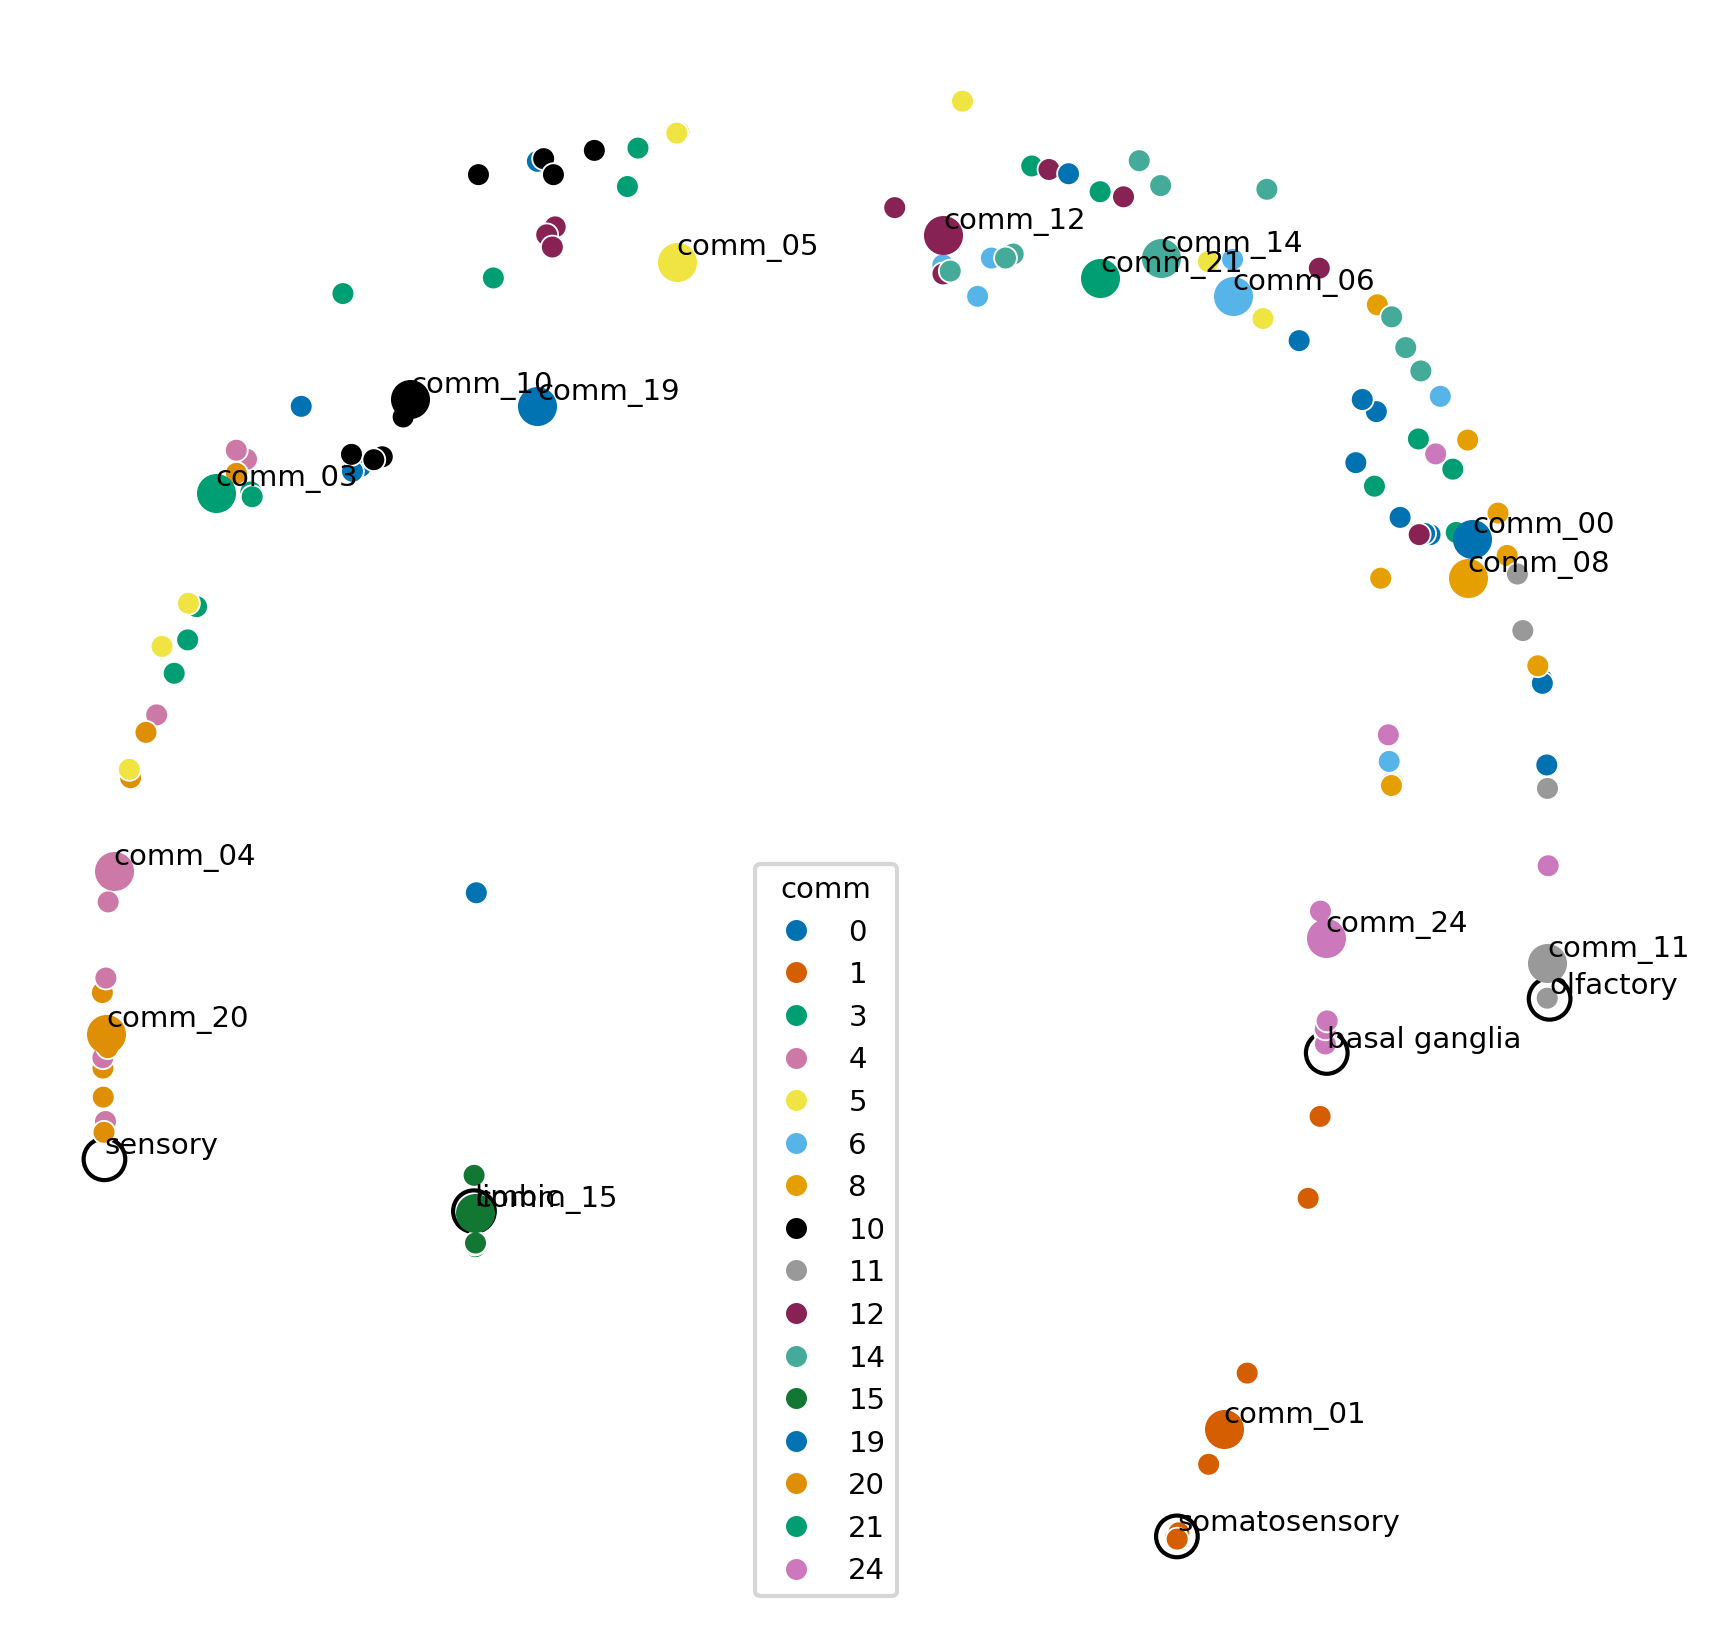

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(493/72, 493/72), dpi=300)

x_offset = 0
y_offset = 0
    
for idx_rsn in range(len(X_rsn)):
    ax.scatter(
        x_rsn[idx_rsn], y_rsn[idx_rsn], 
        s=100, alpha=1.0, #c='black'
        facecolors='none', edgecolors='black',
    )
    ax.text(
        x_rsn[idx_rsn]+x_offset, y_rsn[idx_rsn]+y_offset,
        # f'rsn_{idx_rsn:02d}',
        f'{rsns_df.at[idx_rsn, "name"]}',
        fontsize=7, ha='left', va='bottom',
    )

sns.scatterplot(
    soft_vec_df,
    x='x', y='y',
    ax=ax,
    hue='comm',
    s=30,
    palette=CUD_COLORS,
    alpha=1.0,
)

for idx_row, row in boot_vec_df.iterrows():
    comm = row['comm']
    # sns.kdeplot(
    #     x=row['boot_xs'], y=row['boot_ys'],
    #     ax=ax, 
    #     levels=[0.3],
    #     palette=CUD_COLORS[idx_row],
    #     linewidths=1.0,
    #     label=f'comm_{comm:02d}',
    # )
    ax.scatter(row['x_median'], row['y_median'], marker='o', c=CUD_COLORS[idx_row], s=70, label=f'comm_{comm:02d}')
    ax.text(
        row['x_median']+x_offset, row['y_median']+y_offset, 
        f'comm_{comm:02d}',
        fontsize=7, ha='left', va='bottom',
    )
    
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set(xticks=[], yticks=[], xlabel='', ylabel='')

In [53]:
folder = f'{ESTIM_path}/group/resemblance-with-known-systems/{SBM}'
os.system(f'mkdir -p {folder}')
fig.savefig(f'{folder}/col-{col}_sys-{sys_name}_desc-{measure}-2d-projection-phate.svg', bbox_inches='tight', transparent=True)

## simulate hypothetical situations to understand PHATE embedding

In [54]:
def phate_embedding(X):
    phate_operator = phate.PHATE(n_components=2, knn=5, decay=40, t='auto')
    phate_coords = phate_operator.fit_transform(X)
    return phate_coords

In [55]:
def collect_coords(phate_coords):
    x_rsn = phate_coords[:len(X_rsn), 0]
    y_rsn = phate_coords[:len(X_rsn), 1]

    x_comm = phate_coords[len(X_rsn):, 0]
    y_comm = phate_coords[len(X_rsn):, 1]
    df = pd.DataFrame(dict(
        comm=np.arange(len(x_comm)),
        x=x_comm,
        y=y_comm,
    ))
    return x_rsn, y_rsn, df

In [56]:
def plot_embedding(x_rsn, y_rsn, df, name):
    fig, ax = plt.subplots(1, 1, figsize=(119.3/72, 119.3/72), dpi=300)
    x_offset = 0
    y_offset = 0
    
    for idx_rsn in range(len(X_rsn)):
        ax.scatter(
            x_rsn[idx_rsn], y_rsn[idx_rsn], 
            s=50, alpha=1.0, #c='black'
            facecolors='none', edgecolors='black',
            linewidth=0.5,
        )
        ax.text(
            x_rsn[idx_rsn]+x_offset, y_rsn[idx_rsn]+y_offset,
            f'rsn_{idx_rsn:02d}',
            # f'{rsns_df.at[idx_rsn, "name"]}',
            fontsize=7, ha='left', va='bottom',
        )

    sns.scatterplot(
        df,
        x='x', y='y',
        ax=ax,
        hue='comm',
        s=25,
        palette=CUD_COLORS,
        alpha=1.0,
        # legend=False,
    )
        
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')

    fig.savefig(f'{folder}/sys-{sys_name}_desc-phate-hypothetical-{name}.svg', bbox_inches='tight', transparent=True)

In [116]:
n_rsn = 5
n_comm = 10

# Create prototype specificity vectors for each community
S = np.zeros((n_rsn, n_comm))

# Comm 0 and 1: purely assigned to RSN 0 and RSN 1
S[:, 0] = [1, 0, 0, 0, 0]
S[:, 1] = [0, 1, 0, 0, 0]

# Comm 2: uniform
S[:, 2] = [0.2] * 5

# Comm 3: equal between RSN 1 and RSN 3
S[:, 3] = [0, 0, 0.4, 0, 0.6]

# Comm 4: 70% RSN 0, 30% RSN 2
S[:, 4] = [0.7, 0, 0.3, 0, 0]

# Comm 5–6: gradient RSN 0 → RSN 1
S[:, 5] = [0.8, 0.2, 0, 0, 0]
S[:, 6] = [0.6, 0.4, 0, 0, 0]

# Comm 7: tripartite 0/1/4
S[:, 7] = [0.3, 0.3, 0, 0, 0.4]

# Comm 8: mostly RSN 2 with noise
S[:, 8] = [0.05, 0, 0.9, 0, 0.05]

# Comm 9: mostly RSN 4 with some spread
S[:, 9] = [0.1, 0.1, 0.1, 0.1, 0.6]

# Normalize just in case (though each col already sums to 1)
S = S / S.sum(axis=0)

Calculating PHATE...
  Running PHATE on 15 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculating affinities...
  Calculating optimal t...
    Automatically selected t = 13
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.03 seconds.


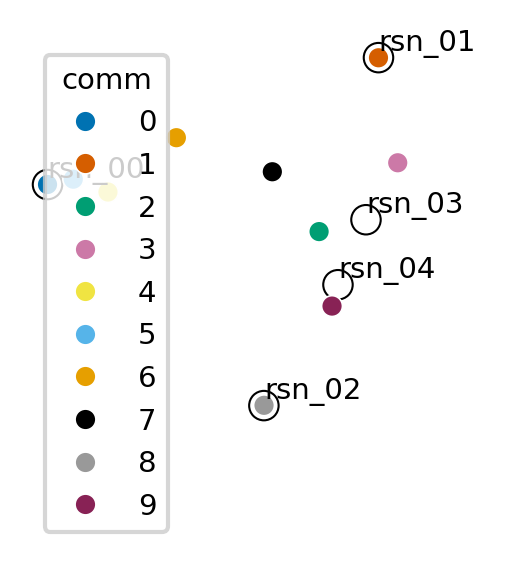

In [58]:
X = np.stack(X_rsn + [S[:, i] for i in range(n_comm)])
phate_coords = phate_embedding(X)
x_rsn, y_rsn, df = collect_coords(phate_coords)
plot_embedding(x_rsn, y_rsn, df, 'combined')

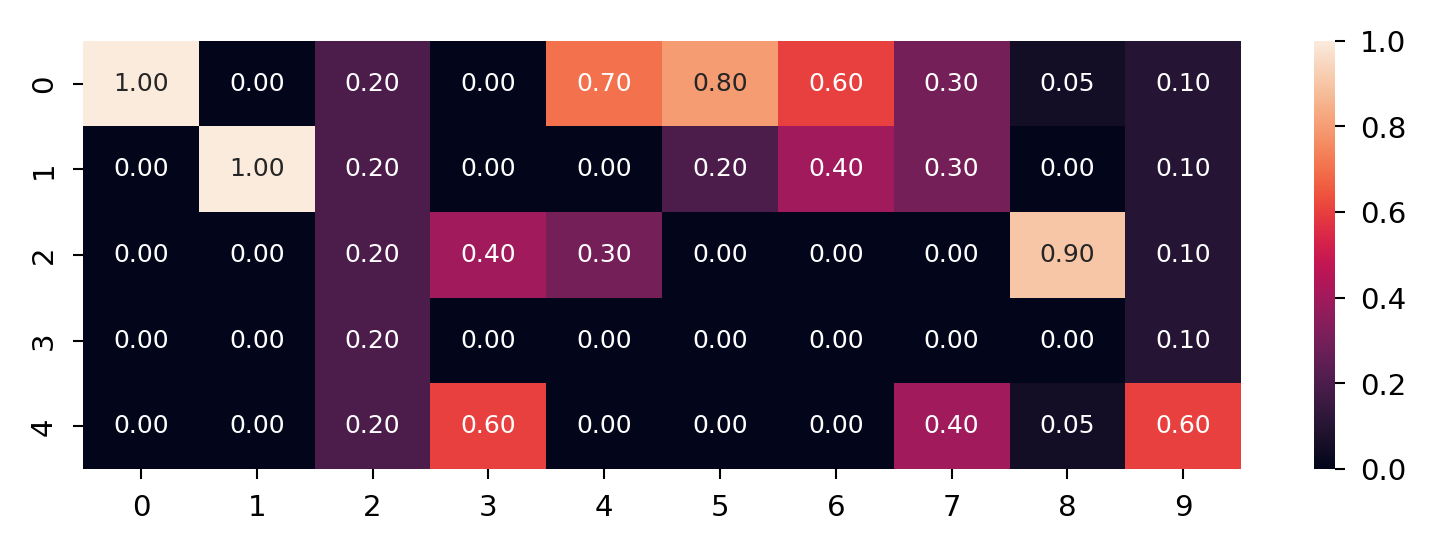

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(450/72.27, 134/72.27))
sns.heatmap(S, annot=True, fmt='.2f', ax=ax, annot_kws={"size": 6})
fig.savefig(f'{folder}/sys-{sys_name}_desc-matrix-hypothetical.svg', bbox_inches='tight', transparent=True)

## barycentric illustration

In [99]:
def get_rsn_positions(n_rsn=5, radius=1.0):
    angles = np.linspace(0, 2*np.pi, n_rsn, endpoint=False)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    return np.vstack([x, y]).T

In [100]:
rsn_pos = get_rsn_positions()
x_rsn, y_rsn = rsn_pos[:, 0], rsn_pos[:, 1]
x_rsn, y_rsn

(array([ 1.        ,  0.30901699, -0.80901699, -0.80901699,  0.30901699]),
 array([ 0.        ,  0.95105652,  0.58778525, -0.58778525, -0.95105652]))

In [101]:
def project_barycentric(S, rsn_pos):
    return (rsn_pos.T @ S).T 

In [102]:
comm_coords = project_barycentric(S, rsn_pos)
comm_coords

array([[ 1.00000000e+00,  0.00000000e+00],
       [ 3.09016994e-01,  9.51056516e-01],
       [-8.81626217e-17,  6.09449695e-18],
       [-1.38196601e-01, -3.35519809e-01],
       [ 4.57294902e-01,  1.76335576e-01],
       [ 8.61803399e-01,  1.90211303e-01],
       [ 7.23606798e-01,  3.80422607e-01],
       [ 5.16311896e-01, -9.51056516e-02],
       [-6.62664445e-01,  4.81453901e-01],
       [ 1.54508497e-01, -4.75528258e-01]])

In [96]:
def plot_barycentric_layout(S, rsn_pos, comm_coords):
    n_comm = S.shape[1]
    
    fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
    
    for i, (x, y) in enumerate(rsn_pos):
        ax.scatter(x, y, s=20, facecolors='none', edgecolors='black')
        ax.text(x, y, f'rsn_{i:01d}', fontsize=7, ha='left', va='bottom')
    
    for p1, p2 in combinations(rsn_pos, 2):
        x0, y0 = p1
        x1, y1 = p2
        ax.plot([x0, x1], [y0, y1], linestyle='--', color='grey', linewidth=0.5, alpha=0.3)
    
    for i in range(len(rsn_pos)):
        x, y = rsn_pos[i, 0], rsn_pos[i, 1]
        ax.plot([0, x], [0, y], linestyle='--', color='grey', linewidth=0.5, alpha=0.3)
    
        
    ax.scatter(comm_coords[:, 0], comm_coords[:, 1], s=5, c=CUD_COLORS[:n_comm])
    # for j, (x, y) in enumerate(comm_coords):
    #     ax.text(x, y, f'comm_{j:01d}', fontsize=5, ha='left', va='bottom')
    
    ax.set_aspect('equal')
    ax.grid(alpha=0.15)
    plt.tight_layout()
    
    return fig

In [103]:
S[:, 3]

array([0. , 0. , 0.4, 0. , 0.6])

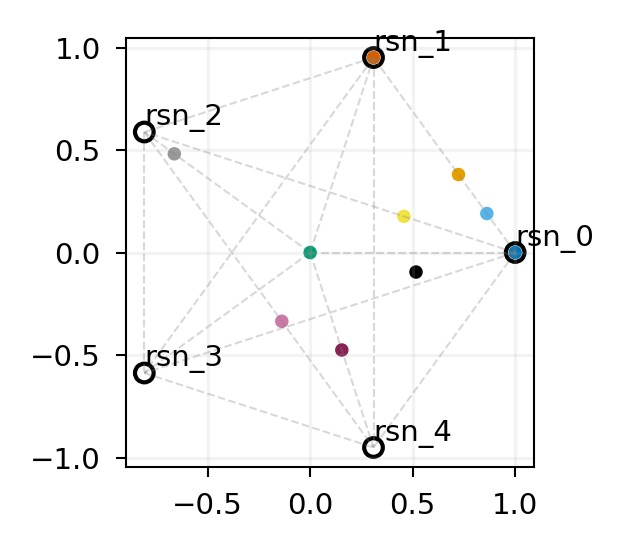

In [104]:
fig = plot_barycentric_layout(S, rsn_pos, comm_coords)
fig.savefig(f'{folder}/sys-{sys_name}_desc-barycentric-hypothetical.svg', bbox_inches='tight', transparent=True)